# 3.1 Operators based on first derivative

Edge detection is an image processing technique for finding those points in images that represent brightness variations or *edges*. It has many applications for image segmentation and data extraction that will be explained posteriorly in this course.

As commented, edges can be defined as transitions between image regions that have different gray levels (intensities). In this way, the unidimensional, continuous model of an ideal edge is:

<img src="./images/model_of_ideal_edge.PNG" width="600">

However, in real images that model is not exactly followed by edges since images are discrete, and they are corrupted by noise.

Moreover, **the nature of edges may be diverse**:
- occlusion borders
- different orientation of surfaces
- different reflectance properties
- different textures
- illumination effects: shadows, reflections, etc.

### Error types related to edge detection

Finding edges properly is not a straightforward task, as there exist different errors that can appear when applying edge detection techniques:
- **Detection error.** A good detector exhibits low ratio of false negative and false positive, that is:
  - False negatives: Existing edges that are not detected.
  - False positives: Detected objects that are not real.
- **Localization error.** Edges are detected, but they are not at the real, exact position.
- **Multiple response.** Multiple detections are raised for the same edge (the edge is thick).

The following figure illustrates such errors.

<img src="./images/edge_errors.jpg" width="400">

Thereby, when designing a good edge detector, the goal is to achieve low detection and localization errors, as well as to avoid multiple responses. 

### Operators based on first derivative (gradient)

In the upcoming chapters, we are going to investigate and implement different edge detection methods. All of them are based on convolution, having their own pros and cons.

Concretely, in this notebook we will cover **first-derivative** based operators, which try to detect borders by looking at abrupt intensity differences in neighbor pixels. In the image below we can see two functions $f(x)$ (first row) and how their derivatives (second row) reach their maximum values at the points where the functions' values change more abruptly (around $x_o$). 

<img src="./images/first_derivative_of_continuous_function.PNG" width="500">$\\[10pt]$

If we are dealing with a **two-dimensional** continuous function $f(x,y)$, its derivative is a *vector* (**gradient**) defined as:$\\[10pt]$
$$
\nabla  f(x,y) = 
\begin{bmatrix} 
\frac{\partial}{\partial x}f(x,y) \\ \frac{\partial}{\partial y}f(x,y) 
\end{bmatrix} 
=
\begin{bmatrix}
f_x(x,y) \\
f_y(x,y)
\end{bmatrix}
$$

which points at the *direction* of maximum (positive) variation of $f(x,y)$:$\\[10pt]$

$$
\alpha(x,y) = \arctan \left(\frac{f_y(x,y)}{f_x(x,y)}\right)
$$

and has a *module* proportional to the strength of this variation:$\\[10pt]$

$$
|\nabla  f(x,y)| = \sqrt{(f_x(x,y))^2 + (f_y(x,y))^2} \approx |f_x(x,y)| + |f_y(x,y)|
$$

The image below shows examples of gradient vectors:$\\[10pt]$

<img src="./images/gradient_examples.PNG" width="700">$\\[10pt]$

Concretely, the techniques based on the first derivative explored here are:

- Discrete approximations of a **gradient operator** (Sobel, Prewitt, Roberts, etc., Section 3.1.1).
- The **Derivative of Gaussian** (DroG) operator (Section 3.1.2).

## Problem context - Edge detection for medical images

Edge detection in medical images is of capital importance for diagnosis of different diseases (e.g., the detection of tumor cells) in human organs such as lungs and prostates, becoming an essential pre-processing step in medical image segmentation.

<img src="./images/hospital_clinico.jpg" width="400">

In this context, *Hospital Clínico*, a very busy hospital in Málaga is asking local engineering students to join their research team. They are looking for a person with knowledge in image processing and, in order to ensure it, they have published 3 medical images: `medical_1.jpg`, `medical_2.jpg` and `medical_3.jpg`. They have asked us to perform accurate edge detection in the three images, as well as to provide an explanation of how it has been made.

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

To face this challenge, we are going to use plenty edge detection methods, which will be tested and compared in order to determine the best option.

### **<span style="color:green"><b><i>ASSIGNMENT 1: Taking a look at images</i></b></span>**

First, **display the provided images** to get an idea about what we are dealing with.

*Note: As most medical images does not provide color information, we are going to use border detection in greyscale images.*

*Tip: Different approaches can be followed for edge detection in color images, like converting to YCrCb color space (appendix 2), or detecting edges on each RGB channel.*

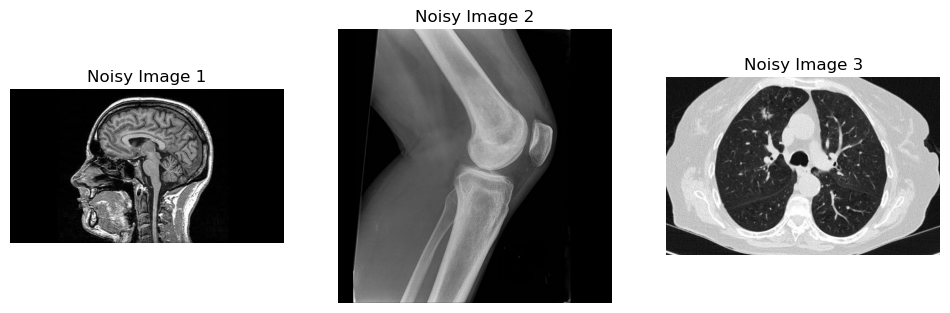

In [11]:
# ASSIGNMENT 1
# Display the provided images in a 1x3 plot to see what are we dealing with
# Write your code here!

# Read the images
im1 = cv2.imread(images_path + 'medical_1.jpg', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(images_path + 'medical_2.jpg', cv2.IMREAD_GRAYSCALE)
im3 = cv2.imread(images_path + 'medical_3.jpg', cv2.IMREAD_GRAYSCALE)

# And show them
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(im1, cmap='gray')
plt.title('Noisy Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(im2, cmap='gray')
plt.title('Noisy Image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(im3, cmap='gray')
plt.title('Noisy Image 3')
plt.axis('off')

plt.show()  

## 3.1.1 Discrete approximations of a gradient operator

The first bunch of methods that we are going to explore carry out a **discrete approximation of a gradient operator** based on the differences between gray (intensity) levels. For example:

<div style="padding: 10px; margin: 0 auto; text-align: center; display: table;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 370px; text-align:left;">- Backward difference of pixels along a row: <br /> $\, \, \, \,f_x(x,y) \approx G_C(i,j)=[F(i,j)-F(i-1,j)]/T$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">1</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table> 
    
</div>

<div style="padding: 10px; margin: 0 auto; text-align: center; display: table;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 370px; text-align:left;">- Symmetric difference of pixels along a row: <br /> $\, \, \, \,f_x(x,y) \approx G_R(i,j)=[F(i+1,j)-F(i-1,j)]/2T$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table>     

</div>

These approximations are typically implemented through the convolution of the image with a pair of templates $H_C$ (for columns, detecting vertical edges) and $H_R$ (for rows, detecting horizontal ones), that is:

$$
G_R(i,j) = F(i,j) \otimes H_R(i,j) \\
G_C(i,j) = F(i,j) \otimes H_C(i,j)
$$

Perhaps the most popular operator doing this is such of **Sobel**, although there are many of them that provide acceptable results. These operators use the aforementioned two kernels (typically of size $3\times3$ or $5\times5$) which are convolved with the original image to calculate approximations of the derivatives. 

These are some examples (first column: operator name; second one: $H_R$; third column: $H_C$):$\\[5pt]$

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Roberts</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;"> </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;"> </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Prewitt</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{3}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 5px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{3}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Sobel</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{4}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-2</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 5px; display: table-cell; vertical-align: middle; width: 50px; text-align:right;">$\frac{1}{4}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-2</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">Frei-Chen</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+\sqrt{2}}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">$\sqrt{2}$</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-$\sqrt{2}$</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+\sqrt{2}}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-$\sqrt{2}$</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">$\sqrt{2}$</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

<div style="padding: 10px; margin: 0 auto; text-align: center;">

<div style = "padding: 0px; display: table-cell; vertical-align: middle; width: 70px; text-align:left;">In general</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+K}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">$K$</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">-$K$</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
	</tbody>
</table>   
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle; width: 70px; text-align:right;">$\frac{1}{2+K}$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">-1</td>
			<td style="border: 1px solid;">-$K$</td>
			<td style="border: 1px solid;">-1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">$K$</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>  

</div>

At this point we know how to perform a discrete approximation of a gradient operator through the application of a convolution operation with two different kernels, that is:

$$\nabla  F(x,y) = 
\begin{bmatrix} 
F \otimes H_C \\ F \otimes H_R
\end{bmatrix}$$

But, how could we use the output of those computations to detect edges? The following figure clarifies that!

<img src="./images/how_to_detect_edges_with_gradient_image2.png" width="350">

**Kernel sizes**

As discussed, kernels can be of different size, and that size directly affects the quality of the detection and the localization (e.g. Sobel $3\times3$ or $5\times5$):
- Small template:
  - more precise localization (good localization).
  - more affected by noise (likely produces false positives).
- Large template:
  - less precise localization.
  - more robust to noise (good detector).
  - higher computational cost ($O(N \times N)$)

### **<span style="color:green"><b><i>ASSIGNMENT 2: Playing with Sobel derivatives</i></b></span>**

Now that we have acquired a basic understanding of these methods, let's employ the Sobel kernels ($S_x,S_y$) to compute both derivatives and display them along with the original image (`medical_3.jpg`).

*Notice that the derivative image values can be positive **and negative**, caused by the negative values in the kernel. This implies that the desired depth of the destination image (`ddepth`) has to be at least a signed data type when calling to the `filter2D()` method.*

In [ ]:
# ASSIGNMENT 2
# Read one of the images, compute both kernel derivatives, apply them to the image (separately) and display the original image and the derivatives in a 1x3 plot.
# Write your code here!

# Read the image


# Define horizontal and vertical kernels


# Apply convolution


# And show them!


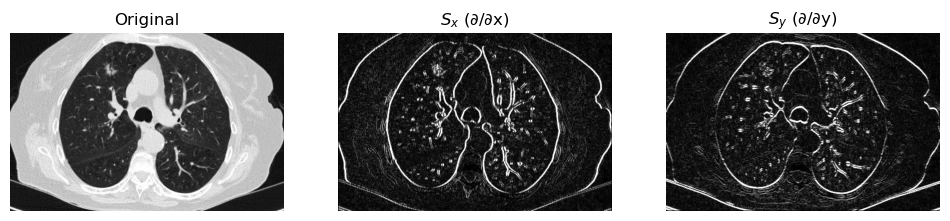

In [15]:
# ASSIGNMENT 2 SOLUTION
# Read one of the images, compute both kernel derivatives, apply them to the image (separately) and display the original image and the derivatives in a 1x3 plot.
# Write your code here!

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load grayscale image (tries .jpg then .png) ---
images_path = Path("./images")  # change if needed
p = images_path / "medical_3.jpg"
if not p.exists():
    p = images_path / "medical_3.png"
img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Could not read {p}")

# --- Sobel kernels ---
Sx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.float32)
Sy = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]], dtype=np.float32)

# --- Convolve (use float for accuracy) ---
gx = cv2.filter2D(img.astype(np.float32), ddepth=-1, kernel=Sx, borderType=cv2.BORDER_REFLECT_101)
gy = cv2.filter2D(img.astype(np.float32), ddepth=-1, kernel=Sy, borderType=cv2.BORDER_REFLECT_101)

# For display: map signed responses to 8-bit via absolute value
gx_disp = cv2.convertScaleAbs(gx)  # abs + saturate to 8-bit
gy_disp = cv2.convertScaleAbs(gy)

# --- Show 1x3 ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gx_disp, cmap='gray'); plt.title('$S_x$ (∂/∂x)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(gy_disp, cmap='gray'); plt.title('$S_y$ (∂/∂y)'); plt.axis('off')
plt.show()


We could also do it using OpenCV's build-in Sobel function.

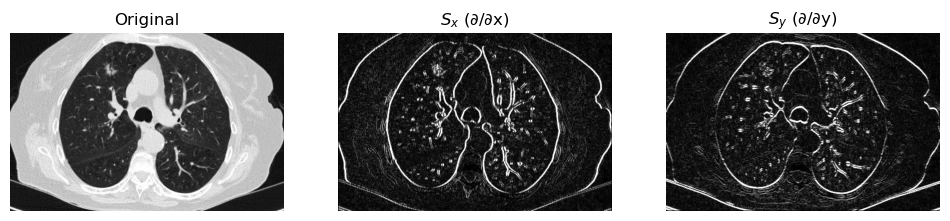

In [16]:
# ASSIGNMENT 2 SOLUTION (OPTION B, using OpenCV built-in Sobel)
# Read one of the images, compute both kernel derivatives, apply them to the image (separately) and display the original image and the derivatives in a 1x3 plot.
# Write your code here!

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load grayscale image (tries .jpg then .png) ---
images_path = Path("./images")  # change if needed
p = images_path / "medical_3.jpg"
if not p.exists():
    p = images_path / "medical_3.png"
img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Could not read {p}")

# --- Sobel kernels ---
Sx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.float32)
Sy = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]], dtype=np.float32)

# --- Convolve (use float for accuracy) ---
gx = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3, borderType=cv2.BORDER_REFLECT_101)
gy = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3, borderType=cv2.BORDER_REFLECT_101)

gx_disp = cv2.convertScaleAbs(gx)
gy_disp = cv2.convertScaleAbs(gy)


# --- Show 1x3 ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gx_disp, cmap='gray'); plt.title('$S_x$ (∂/∂x)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(gy_disp, cmap='gray'); plt.title('$S_y$ (∂/∂y)'); plt.axis('off')
plt.show()


Once we have computed both derivative images $G_C$ and $G_R$, we can determine the complete edge image by computing the image gradient magnitude and then binarizing the result:

$$|\nabla F(x,y)| = \sqrt{(F \otimes G_C)^2 + (F \otimes G_R)^2} \approx |F \otimes G_C| + |F \otimes G_R|$$

### **<span style="color:green"><b><i>ASSIGNMENT 3a: Time to detect edges</i></b></span>**

Complete `edge_detection_chart()` that computes the gradient image of an input one using `kernel_h` and `kernel_v` (kernels for horizontal and vertical derivatives respectively) and **binarize the resultant image** (final edges image) using `threshold`. Then display in a 1x3 plot `image`, the gradient image, and finally, an image with the detected edges! (Only if `verbose` is True).

*Tip: you should [normalize](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize) gradient image before thresholding.*

In [ ]:
# ASSIGNMENT 3a
# Implement a function that that computes the gradient of an image, taking also as input the convolution kernels.
# It must also binarize the resulting image using a threshold
# Show the input image, the gradient image (normalized) and the binarized edge image in a 1x3 plot (if verbose = True)
def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False):
    """ Computed the gradient of the image, binarizes and display it.   
    
        Args:
            image: Input image
            kernel_h: kernel for horizontal derivative
            kernel_v: kernel for vertical derivative
            threshold: threshold value for binarization
            verbose: Only show images if this is True
            
        Returns:
            edges: edges binary image
    """
    
    # Compute derivatives
    
    
    # Compute gradient
    
    
    #Normalize gradient
    
    
    # Threshold to get edges
    
    
    if verbose:
        # Show the initial image
        

        # Show the gradient image
        

        # Show edges image
        

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False,
                         borderType=cv2.BORDER_REFLECT_101):
    """
    Computes image gradients with given kernels, normalizes the magnitude,
    thresholds to get a binary edge map, and optionally plots results.

    Args:
        image: input image (H×W or H×W×3, uint8/float).
        kernel_h: kernel for horizontal derivative (Sx)  shape 3×3 (or odd×odd)
        kernel_v: kernel for vertical   derivative (Sy)
        threshold: binarization threshold; if <=1 it's treated as a normalized
                   threshold on [0,1], otherwise interpreted on [0,255].
        verbose: show Original | Gradient | Edges when True.
        borderType: OpenCV border handling (default REFLECT_101).

    Returns:
        edges: uint8 binary image (0 or 255).
    """
    # --- Ensure grayscale float32 ---
    if image.ndim == 3:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = image
    img_f = img_gray.astype(np.float32)

    # --- Make sure kernels are float32 ---
    kx = np.asarray(kernel_h, dtype=np.float32)
    ky = np.asarray(kernel_v, dtype=np.float32)

    # --- Derivatives (correlation; for Sobel symmetry doesn’t matter) ---
    gx = cv2.filter2D(img_f, ddepth=-1, kernel=kx, borderType=borderType)
    gy = cv2.filter2D(img_f, ddepth=-1, kernel=ky, borderType=borderType)

    # --- Gradient magnitude ---
    grad = np.hypot(gx, gy)  # sqrt(gx**2 + gy**2)

    # --- Normalize to [0,1] for display/thresholding ---
    gmin, gmax = float(grad.min()), float(grad.max())
    grad_norm = (grad - gmin) / (gmax - gmin + 1e-8)

    # --- Threshold (supports 0–1 or 0–255 input) ---
    thr = threshold if threshold <= 1.0 else threshold / 255.0
    edges = (grad_norm >= thr).astype(np.uint8) * 255  # binary 0/255

    if verbose:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img_gray, cmap='gray'); plt.axis('off')
        plt.subplot(1, 3, 2); plt.title("Gradient (norm)"); plt.imshow(grad_norm, cmap='gray', vmin=0, vmax=1); plt.axis('off')
        plt.subplot(1, 3, 3); plt.title(f"Edges (thr={thr:.2f})"); plt.imshow(edges, cmap='gray'); plt.axis('off')
        plt.show()

    return edges


You can use next code to **test if your results are correct**:

In [18]:
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

print(edge_detection_chart(image, kernel_h, kernel_v, 100))

[[  0   0   0]
 [255 255 255]
 [  0 255   0]]


<font color='blue'>**Expected output:**  </font>

    [[  0   0   0]
     [255 255 255]
     [  0 255   0]]

### **<span style="color:green"><b><i>ASSIGNMENT 3b: Testing our detector</i></b></span>**

Now **try the implemented method** with different size Sobel kernels ($3\times3$, $5\times5$, ...) and with other operators (Roberts, Prewitt, ...). $\\[5pt]$  

In [20]:
import numpy as np

image = np.array([[10,60,20],
                  [60,22,74],
                  [72,132,2]], dtype=np.uint8)

# --- pick one: 'Sobel3' | 'Sobel5' | 'Prewitt3' | 'Roberts' | 'Scharr'
op = 'Roberts'

if op == 'Sobel3':
    kernel_h = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)/4
    kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], np.float32)/4
elif op == 'Sobel5':
    kernel_h = np.array([[ -1,-2, 0, 2, 1],
                         [ -4,-8, 0, 8, 4],
                         [ -6,-12,0,12,6],
                         [ -4,-8, 0, 8, 4],
                         [ -1,-2, 0, 2, 1]], np.float32)/48
    kernel_v = kernel_h.T
elif op == 'Prewitt3':
    kernel_h = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], np.float32)/3
    kernel_v = np.array([[ 1, 1, 1],[0,0,0],[-1,-1,-1]], np.float32)/3
elif op == 'Roberts':
    kernel_h = np.array([[1,0],[0,-1]], np.float32)
    kernel_v = np.array([[0,1],[-1,0]], np.float32)
elif op == 'Scharr':
    kernel_h = np.array([[ 3, 0,-3],[10, 0,-10],[ 3, 0,-3]], np.float32)/32
    kernel_v = np.array([[ 3,10, 3],[ 0, 0, 0],[-3,-10,-3]], np.float32)/32

print(edge_detection_chart(image, kernel_h, kernel_v, 100))


[[  0   0   0]
 [  0   0   0]
 [255 255 255]]


### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer following questions**:

- What happens if we use a bigger kernel?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- There are differences between Sobel and other operators?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  
    
- What errors appear using those operators?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  
    
- Why kernels usually are divided by a number? (e.g. $3\times3$ Sobel is divided by 4)

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

## 3.1.2 DroG operator

Despite the simplicity of the previous techniques, they have a remarkable drawback: their performance is highly influenced by image noise. Taking a look at the following figure we can see how, having an apparently not so noisy function (first row), where it is easy to detect a step (an abrupt change in its values) around 1000, the response of the derivative with that level of noise is as bigger as the step itself!$\\[5pt]$

<img src="./images/example_of_derivative_of_noisy_function.PNG" width="600"><br />
<center><i>Source: S. Seitz</i></center>$\\[5pt]$

But not everything is lost! An already studied image processing technique can be used to mitigate such noise: **image smoothing**, and more concretely, **Gaussian filtering!**. The basic idea is to smooth the image and then apply a gradient operator, that is to compute $\frac{\partial}{\partial x}(f \otimes g)$. Not only that, this can be done even more efficiently thanks to the convolution derivative property:$\\[5pt]$

$$\frac{\partial}{\partial x}(f \otimes g) = f \otimes \frac{\partial}{\partial x}g
$$$\\[5pt]$

That is, precomputing the resultant kernels from the convolution of the Gaussisan filtering and the Sobel ones, and then convolving them with the image to be processed. With that we save one operation!$\\[5pt]$

This combination of smoothing and gradient is usually called **Derivative of Gaussian operator (DroG)**:$\\[5pt]$

$$
\nabla [f(x,y)\otimes g_\sigma(x,y)] = 
f(x,y) \otimes \nabla [g_\sigma(x,y)] = 
f(x,y) \otimes \text{DroG} (x,y)
$$

$$
DroG(x,y) = 
\nabla \left[ g_\sigma (x,y) \right] = 
\underbrace{\begin{bmatrix} 
\frac{\partial}{\partial x}[g_\sigma(x)g_\sigma(y)] \\ 
\frac{\partial}{\partial y}[g_\sigma(x)g_\sigma(y)] \end{bmatrix}}_{\text{separability}} = 
\underbrace{\begin{bmatrix} \frac{-xg_\sigma(x,y)}{\sigma^2} \\ \frac{-yg_\sigma(x,y)}{\sigma^2}\end{bmatrix}}_{g(x)'=-xg(x)/\sigma^2}
$$

Remember from the previous notebooks the expression of the Gaussian distribution with 2 variables, where the standard deviation $\sigma$ controls the degree of smoothness: 
 
$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

Take into account that the DroG template or kernel is created just once!

### **<span style="color:green"><b><i>ASSIGNMENT 4: Applying DroG</i></b></span>**

We would like to try this robust edge detection technique, so complete the `gaussian_kernel()` method that constructs a Gaussian filter and then derives it, getting the DroG template. Finally, it calls `edge_detection_chart()` using that template. 

Its inputs are: 
- an image to be processed,
- the kernel aperture size,
- the standard deviation, and
- the gradient image binaritazion threshold.

In [ ]:
# ASSIGNMENT 4
# Implement a function that builds the horizontal and vertical DroG templates and calls to 'edge_detection_chart' using that templates. 
# Inputs: an image, the kernel aperture size, the Gaussian standard deviation and the threshold for the gradient image binarization
# It returns the horizontal and vertical kernels
def gaussian_kernel(image, w_kernel, sigma, threshold, verbose=False):
    """ Construct the DroG operator and call edge_detection_chart.   
    
        Args:
            image: Input image
            w_kernel: Kernel aperture size
            sigma: Standard deviation of the Gaussian distribution
            threshold: Threshold value for binarization
            verbose: Only show images if this is True
            
        Returns:
            kernel_h, kernel_v: DroG horizontal and vertical derivatives
    """
    
    # Create Gaussian filter
    
    
    # Define x and y axis
    
    
    # Construct DroG
    
    
    # Call edge detection chart using DroG


In [25]:
# ASSIGNMENT 4 SOLUTION
# Implement a function that builds the horizontal and vertical DroG templates and calls to 'edge_detection_chart' using that templates. 
# Inputs: an image, the kernel aperture size, the Gaussian standard deviation and the threshold for the gradient image binarization
# It returns the horizontal and vertical kernels

import numpy as np

def gaussian_kernel(image, w_kernel, sigma, threshold, verbose=False):
    x = np.arange(-w_kernel, w_kernel + 1, dtype=np.float32)

    # Gaussian with analytic normalization (NO sum-to-1 renorm)
    g  = np.exp(-(x**2)/(2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
    dg = -(x/(sigma**2)) * g  # derivative of Gaussian

    # Derivative-of-Gaussian (DroG) kernels (NO extra scaling)
    kernel_h = np.outer(g,  dg).astype(np.float32)  # ∂/∂x
    kernel_v = np.outer(dg, g ).astype(np.float32)  # ∂/∂y

    # call your chart if desired
    _ = edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=verbose)

    return kernel_h, kernel_v



You can use next code to **test if results are correct**:

In [26]:
# Create an input image
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

# Apply the Gaussian kernel
gaussian_kernel(image, w_kernel=1, sigma=1.2, threshold=100)

(array([[ 0.03832673, -0.        , -0.03832673],
        [ 0.05423735, -0.        , -0.05423735],
        [ 0.03832673, -0.        , -0.03832673]], dtype=float32),
 array([[ 0.03832673,  0.05423735,  0.03832673],
        [-0.        , -0.        , -0.        ],
        [-0.03832673, -0.05423735, -0.03832673]], dtype=float32))

<font color='blue'>**Expected output:**  </font>

    (array([[ 0.03832673, -0.        , -0.03832673],
            [ 0.05423735, -0.        , -0.05423735],
            [ 0.03832673, -0.        , -0.03832673]]),
     array([[ 0.03832673,  0.05423735,  0.03832673],
            [-0.        , -0.        , -0.        ],
            [-0.03832673, -0.05423735, -0.03832673]]))

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now **try this method** and play with interactive parameters. Then **answer the following questions**:

- What happens if a bigger kernel is used?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What kind of errors appear and disappear whenever sigma is modified?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   
    
- Why the gradient image have lower values than the one from the original image? *Tip: [image normalization](https://stackoverflow.com/questions/40645985/opencv-python-normalize-image/42164670)* 

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   
    
- Now that you have tried different techniques, in your opinion, which is the best one for this type of images?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

In [28]:
# Read the medical_3.jpg image

# --- Load grayscale image (tries .jpg then .png) ---
images_path = Path("./images")  # change if needed
p = images_path / "medical_3.jpg"
if not p.exists():
    p = images_path / "medical_3.png"
img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Could not read {p}")


# Interact with the three input parameters
interactive(gaussian_kernel, image=fixed(image), w_kernel=(1,5,1), sigma=(0.4,5,0.5), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=3, description='w_kernel', max=5, min=1), FloatSlider(value=2.4, descrip…

<div style="max-width:900px;margin:16px auto;font-family:system-ui,Segoe UI,Roboto,Arial,sans-serif;line-height:1.45;">
  <h3 style="margin:0 0 8px;">DroG Edge Detection — Parameter Guide</h3>

  <h4 style="margin:12px 0 6px;">What you see in the widget</h4>
  <ul style="margin:0 0 10px;">
    <li><b>Original</b> – input image.</li>
    <li><b>Gradient (norm)</b> – normalized magnitude ‖∇I<sub>σ</sub>‖.</li>
    <li><b>Edges</b> – binary map after thresholding (title shows thr on [0,1]).</li>
  </ul>

  <h4 style="margin:12px 0 6px;">Parameters</h4>
  <ul style="margin:0 0 10px;">
    <li><b>Sigma (σ)</b>: blur-before-differentiate scale.
      <ul>
        <li><i>Small σ (≈0.5–1):</i> sharp edges, noise sensitive.</li>
        <li><i>Large σ (≥2):</i> noise reduced, edges wider & lower amplitude (≈1/σ) → use a lower threshold.</li>
      </ul>
    </li>
    <li><b>w_kernel</b>: radius; kernel size = (2w+1).
      <ul>
        <li><b>Rule of thumb</b>: w ≈ ⌈3σ⌉ → size ≈ 6σ+1 (avoids truncating the Gaussian).</li>
        <li>Too small w for a large σ ⇒ under-estimated gradients (faint edges).</li>
      </ul>
    </li>
    <li><b>Threshold</b> (slider 0–255 → thr = value/255 on [0,1]):
      <ul>
        <li>Higher thr ⇒ only strongest edges remain.</li>
        <li>As σ increases (edges weaken), reduce thr accordingly.</li>
      </ul>
    </li>
  </ul>

  <h4 style="margin:12px 0 6px;">Practical presets</h4>
  <table style="border-collapse:collapse;width:100%;font-size:14px;">
    <thead>
      <tr>
        <th style="border:1px solid #ccc;padding:6px;background:#f6f8fa;text-align:left;">Scenario</th>
        <th style="border:1px solid #ccc;padding:6px;background:#f6f8fa;text-align:left;">σ</th>
        <th style="border:1px solid #ccc;padding:6px;background:#f6f8fa;text-align:left;">w (radius)</th>
        <th style="border:1px solid #ccc;padding:6px;background:#f6f8fa;text-align:left;">Threshold (norm)</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="border:1px solid #ddd;padding:6px;">Crisp edges, light noise</td>
        <td style="border:1px solid #ddd;padding:6px;">≈ 1.0</td>
        <td style="border:1px solid #ddd;padding:6px;">≈ 3 (size 7×7)</td>
        <td style="border:1px solid #ddd;padding:6px;">0.20–0.35</td>
      </tr>
      <tr>
        <td style="border:1px solid #ddd;padding:6px;">Noisy images</td>
        <td style="border:1px solid #ddd;padding:6px;">1.5–2.5</td>
        <td style="border:1px solid #ddd;padding:6px;">⌈3σ⌉</td>
        <td style="border:1px solid #ddd;padding:6px;">0.10–0.25</td>
      </tr>
      <tr>
        <td style="border:1px solid #ddd;padding:6px;">Large scale edges</td>
        <td style="border:1px solid #ddd;padding:6px;">≥ 3</td>
        <td style="border:1px solid #ddd;padding:6px;">⌈3σ⌉ (big kernel)</td>
        <td style="border:1px solid #ddd;padding:6px;">≤ 0.15</td>
      </tr>
    </tbody>
  </table>

  <h4 style="margin:12px 0 6px;">Why edges may disappear</h4>
  <p style="margin:0;">
    If σ is large and w is small (Gaussian truncated), gradient amplitudes shrink; with a high threshold most edges vanish.
    Increase <b>w_kernel</b> to ≈⌈3σ⌉ and/or lower <b>threshold</b>.
  </p>
</div>


### **<span style="color:green"><b><i>ASSIGNMENT 5: Measuring efficiency</i></b></span>**

Finally, **you are asked to** compare the execution time of creating a DroG template using your previous code (combining two 1-D gaussian filters), with creating a DroG template using a 2-D gaussian filter. *Use a great aperture size (e.g 500)*.

*Tip: [how to measure execution time in Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)*

In [ ]:
# ASSIGNMENT 5

import time

print("Measuring the execution time needed for ...")
      
# Start timer

# Create 1D Gaussian filter


# Define x and y axis


# Construct DroG using 1D Gaussian filters


# Stop timer


# Start timer


# Create 2D Gaussian filter


# Define x and y axis


# Construct DroG using 2D Gaussian filter


# Stop timer

In [29]:
# ASSIGNMENT 5 SOLUTION

import numpy as np, time

# params
w_kernel = 500       # -> kernel size = 2*w+1 = 1001
sigma    = 2.0
x = np.arange(-w_kernel, w_kernel+1, dtype=np.float32)

print("Measuring the execution time needed for ...")

# ---------- 1) Separable 1D Gaussians ----------
t0 = time.perf_counter()
g  = np.exp(-(x**2)/(2*sigma**2)) / (sigma*np.sqrt(2*np.pi))   # 1D Gaussian
dg = -(x/(sigma**2)) * g                                       # 1D derivative
Kx_1d = np.outer(g,  dg)                                       # ∂G/∂x
Ky_1d = np.outer(dg, g )                                       # ∂G/∂y
t1 = time.perf_counter()
print(f"1D method: {t1 - t0:.4f} s, kernel shape = {Kx_1d.shape}")

# ---------- 2) Full 2D Gaussian ----------
t2 = time.perf_counter()
X, Y = np.meshgrid(x, x, indexing='xy')
G2 = np.exp(-(X**2 + Y**2)/(2*sigma**2)) / (2*np.pi*sigma**2)  # 2D Gaussian
Kx_2d = -(X/(sigma**2)) * G2                                   # ∂G/∂x
Ky_2d = -(Y/(sigma**2)) * G2                                   # ∂G/∂y
t3 = time.perf_counter()
print(f"2D method: {t3 - t2:.4f} s, kernel shape = {Kx_2d.shape}")

# (optional) sanity check: they should be (nearly) identical
print("max |Δ| (Kx):", float(np.max(np.abs(Kx_1d - Kx_2d))))
print("max |Δ| (Ky):", float(np.max(np.abs(Ky_1d - Ky_2d))))


Measuring the execution time needed for ...
1D method: 0.0049 s, kernel shape = (1001, 1001)
2D method: 0.0707 s, kernel shape = (1001, 1001)
max |Δ| (Kx): 5.212421813616253e-10
max |Δ| (Ky): 5.212421813616253e-10


1D method builds two vectors (g, dg) and takes outer products → typically faster & less memory.

2D method builds full X, Y grids and the 2D Gaussian → heavier; expect longer time.

## Conclusion

Awesome! Now you have expertise in more applications of the convolution operator. In this notebook you:

- Learned basic operators for edge detection that perform a **discrete approximation of a gradient operator**.
- Learned **how to construct a DroG kernel** in an efficient way.
- Layed a bit with them in the context of medical images, discovering some real and important utilities.